# Tilapia Regression Model with SARIMA
By Miguel Andre R. Pajarillo

## Load the Dataset

In [1]:
import pandas as pd

In [2]:
Tilapia_UN = pd.read_csv('./data/rice_UN_rice_UN.csv.csv')

In [3]:
Tilapia_DA = pd.read_csv('./data/rice_DA_rice_DA.csv.csv')

In [4]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,80,"Rice (regular, milled) - Retail",5,KG,1,2000,18.00
1,80,"Rice (regular, milled) - Retail",5,KG,1,2000,17.80
2,80,"Rice (regular, milled) - Retail",5,KG,1,2000,18.10
3,80,"Rice (regular, milled) - Retail",5,KG,1,2000,16.90
4,80,"Rice (regular, milled) - Retail",5,KG,1,2000,16.10
...,...,...,...,...,...,...,...
3580,80,"Rice (regular, milled) - Retail",5,KG,6,2021,37.15
3581,80,"Rice (regular, milled) - Retail",5,KG,6,2021,36.44
3582,80,"Rice (regular, milled) - Retail",5,KG,6,2021,36.03
3583,80,"Rice (regular, milled) - Retail",5,KG,6,2021,44.13


In [5]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,"Rice (local, regular, milled) - Retail",NaN,KG,1,2022,37.23
1,NaN,"Rice (local, regular, milled) - Retail",NaN,KG,2,2022,37.07
2,NaN,"Rice (local, regular, milled) - Retail",NaN,KG,3,2022,37.06
3,NaN,"Rice (local, regular, milled) - Retail",NaN,KG,4,2022,37.17
4,NaN,"Rice (local, regular, milled) - Retail",NaN,KG,5,2022,37.24


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [6]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [7]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [8]:
Tilapia_UN.head()

,mp_price,date
0,18.0,2000-01-15
1,17.8,2000-01-15
2,18.1,2000-01-15
3,16.9,2000-01-15
4,16.1,2000-01-15


### DA Bantay Presyo

In [9]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tilapia_DA.head()

,mp_price,date
0,37.23,2022-01-15
1,37.07,2022-02-15
2,37.06,2022-03-15
3,37.17,2022-04-15
4,37.24,2022-05-15


In [12]:
import matplotlib.pyplot as plt

In [13]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

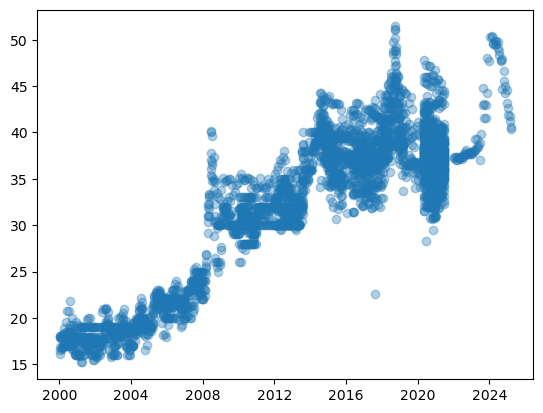

<Figure size 5000x600 with 0 Axes>

In [14]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [15]:
from datetime import datetime

In [16]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [17]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [18]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [19]:
print("🕓 Index Range:")
print(f"Start: {Tilapia.index.min()}")
print(f"End:   {Tilapia.index.max()}")
print(f"Index type: {type(Tilapia.index)}\n")

🕓 Index Range:
Start: 2000-01-01 00:00:00
End:   2025-03-01 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>



In [20]:
start_date = datetime(2000,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

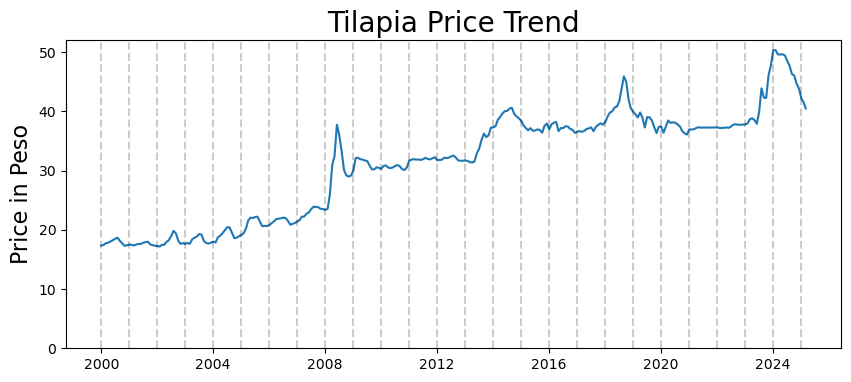

In [21]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [22]:
first_diff = lim_tilapia.diff()[1:]

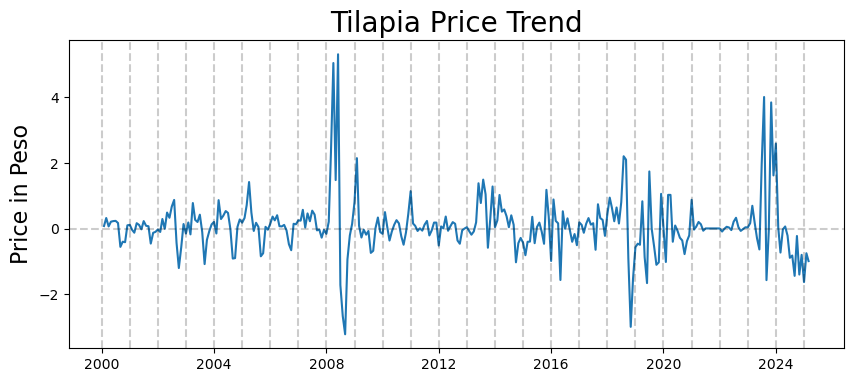

In [23]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [24]:
from statsmodels.tsa.stattools import acf, pacf

<BarContainer object of 25 artists>

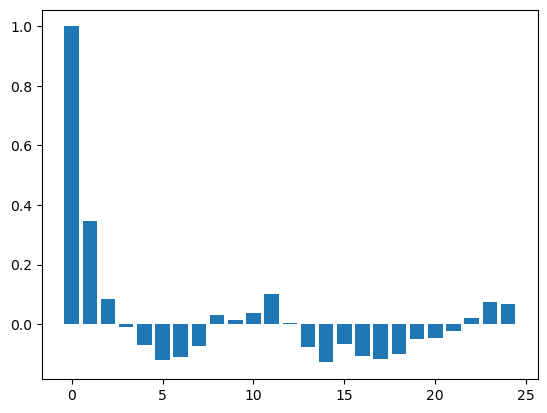

In [25]:
acf_vals = acf(first_diff)
num_lags = 25
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 25 artists>

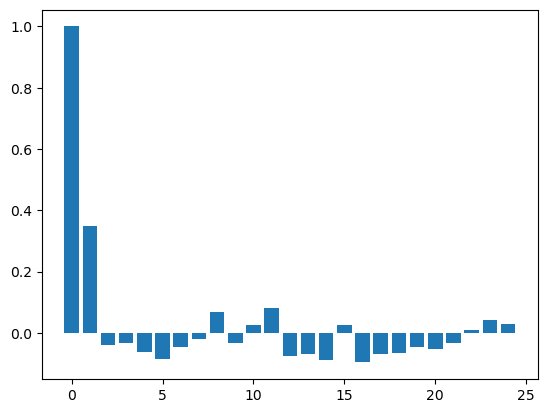

In [26]:
pacf_vals = pacf(first_diff)
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [27]:
from datetime import timedelta

In [28]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [29]:
Tilapia.describe()

,mp_price
count,303.000000
mean,31.210299
std,8.972216
min,17.178571
25%,21.609524
50%,32.188333
75%,37.666176
max,50.355000


## Fit the SARIMA Model

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [32]:
from time import time

In [33]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27554D+00    |proj g|=  1.14343D-01

At iterate    5    f=  1.27234D+00    |proj g|=  1.26097D-02

At iterate   10    f=  1.26401D+00    |proj g|=  1.67914D-02


 This problem is unconstrained.



At iterate   15    f=  1.26306D+00    |proj g|=  6.04829D-03

At iterate   20    f=  1.26272D+00    |proj g|=  3.19710D-03

At iterate   25    f=  1.26270D+00    |proj g|=  3.00938D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     32      1     0     0   3.154D-06   1.263D+00
  F =   1.2627009761724517     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Fitting Time: 0.38675451278686523


In [34]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                  297
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -375.022
Date:                              Thu, 22 May 2025   AIC                            756.044
Time:                                      10:40:40   BIC                            767.115
Sample:                                  01-01-2000   HQIC                           760.477
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9819      0.061     16.128      0.000       0.863       1.101
ma.S.L12      -0.94

In [35]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01    46.075
2024-11-01    44.675
2024-12-01    43.875
2025-01-01    42.245
2025-02-01    41.495


In [36]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [37]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [38]:
predictions

date
2024-10-01    46.039083
2024-11-01    46.065535
2024-12-01    46.146338
2025-01-01    46.276689
2025-02-01    46.344660
2025-03-01    46.482123
Freq: MS, Name: predicted_mean, dtype: float64

In [39]:
residuals

date
2024-10-01    0.035917
2024-11-01   -1.390535
2024-12-01   -2.271338
2025-01-01   -4.031689
2025-02-01   -4.849660
2025-03-01   -5.977123
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

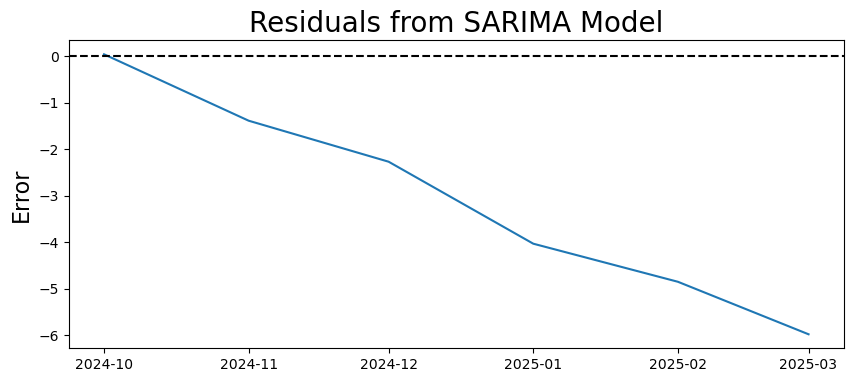

In [40]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

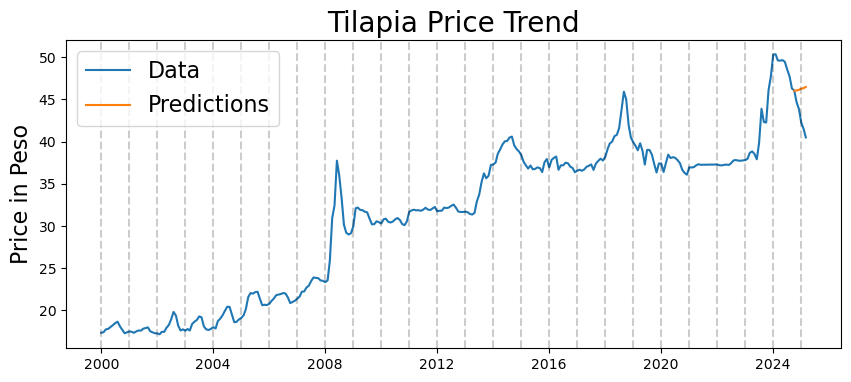

In [41]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [42]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27554D+00    |proj g|=  1.14343D-01

At iterate    5    f=  1.27234D+00    |proj g|=  1.26097D-02

At iterate   10    f=  1.26401D+00    |proj g|=  1.67914D-02


 This problem is unconstrained.



At iterate   15    f=  1.26306D+00    |proj g|=  6.04829D-03

At iterate   20    f=  1.26272D+00    |proj g|=  3.19710D-03

At iterate   25    f=  1.26270D+00    |proj g|=  3.00938D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     32      1     0     0   3.154D-06   1.263D+00
  F =   1.2627009761724517     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27395D+00    |proj g|=  1.14014D-01


/tmp/ipykernel_87533/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate    5    f=  1.27075D+00    |proj g|=  1.26222D-02

At iterate   10    f=  1.26229D+00    |proj g|=  1.62934D-02

At iterate   15    f=  1.26143D+00    |proj g|=  5.58076D-03

At iterate   20    f=  1.26104D+00    |proj g|=  3.44837D-03

At iterate   25    f=  1.26102D+00    |proj g|=  4.37562D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     32      1     0     0   1.092D-05   1.261D+00
  F =   1.2610217086521456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

/tmp/ipykernel_87533/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   15    f=  1.26507D+00    |proj g|=  9.70152D-03

At iterate   20    f=  1.26408D+00    |proj g|=  2.05815D-03

At iterate   25    f=  1.26393D+00    |proj g|=  9.84640D-04

At iterate   30    f=  1.26390D+00    |proj g|=  5.29879D-04

At iterate   35    f=  1.26389D+00    |proj g|=  6.54013D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     59      1     0     0   1.229D-03   1.264D+00
  F =   1.2638914155919785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

/tmp/ipykernel_87533/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate    5    f=  1.27509D+00    |proj g|=  5.29996D-03

At iterate   10    f=  1.27158D+00    |proj g|=  1.16522D-01

At iterate   15    f=  1.26555D+00    |proj g|=  1.56929D-02

At iterate   20    f=  1.26426D+00    |proj g|=  5.83539D-04

At iterate   25    f=  1.26400D+00    |proj g|=  2.76325D-04

At iterate   30    f=  1.26397D+00    |proj g|=  2.91646D-04

At iterate   35    f=  1.26396D+00    |proj g|=  2.53719D-04

At iterate   40    f=  1.26396D+00    |proj g|=  2.41057D-04

At iterate   45    f=  1.26396D+00    |proj g|=  2.52907D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     45     66   

/tmp/ipykernel_87533/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   10    f=  1.27498D+00    |proj g|=  7.53787D-02

At iterate   15    f=  1.27074D+00    |proj g|=  2.18410D-02

At iterate   20    f=  1.26944D+00    |proj g|=  7.69625D-04

At iterate   25    f=  1.26917D+00    |proj g|=  2.21765D-04

At iterate   30    f=  1.26911D+00    |proj g|=  5.19634D-04
  ys=-5.733E-06  -gs= 1.034E-05 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_87533/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   35    f=  1.26909D+00    |proj g|=  5.84724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     64      1     1     0   5.847D-04   1.269D+00
  F =   1.2690947572338442     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28232D+00    |proj g|=  1.11528D-01

At iterate    5    f=  1.27938D+00    |proj g|=  2.44193D-03

At iterate   10    f=  1.27693D+00    |proj g|=  1.16113D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_87533/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [43]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

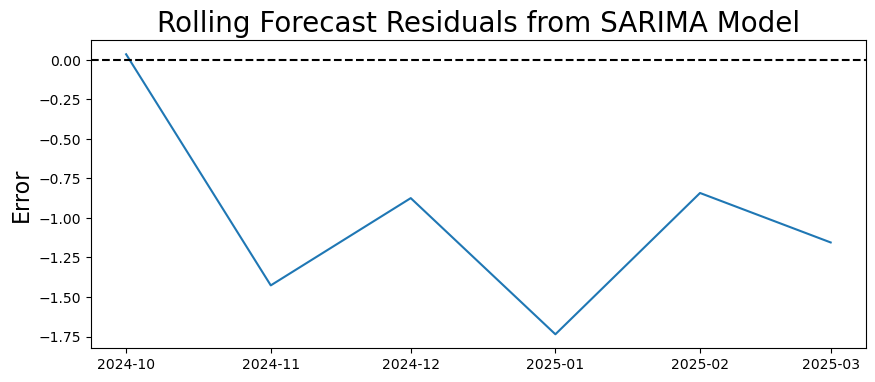

In [44]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

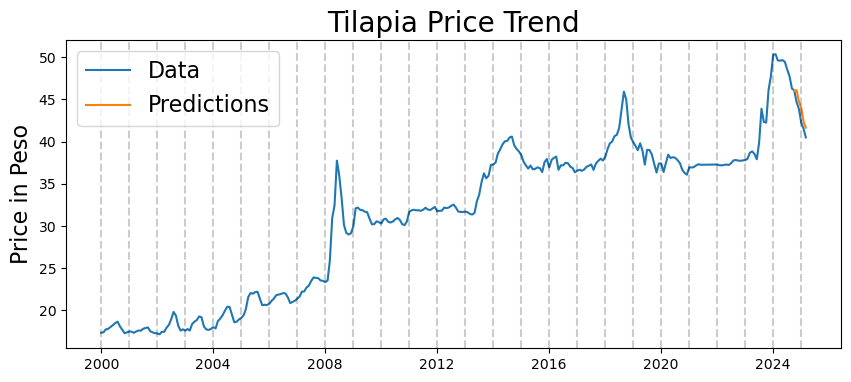

In [45]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [46]:
import numpy as np

In [47]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.0238


In [48]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1.1442621188388447


## Future Predictions (2025)

In [60]:
#get the predictions and residuals
predictions = model_fit.forecast(12)
# Rice 100g * 10 = 1kg
protein = 1.94*10
carbs = 79.8*10
fats = 1.3*10
fiber = 0.5*10

protein_projection = protein / predictions
carbs_projection = carbs / predictions
fats_projection = fats / predictions
fiber_projection = fiber / predictions

protein_projection.to_csv('./protein.csv', index=True)
carbs_projection.to_csv('./carbs.csv', index=True)
fats_projection.to_csv('./fats.csv', index=True)
fiber_projection.to_csv('./fiber.csv', index=True)

Text(0, 0.5, 'Protein in Grams')

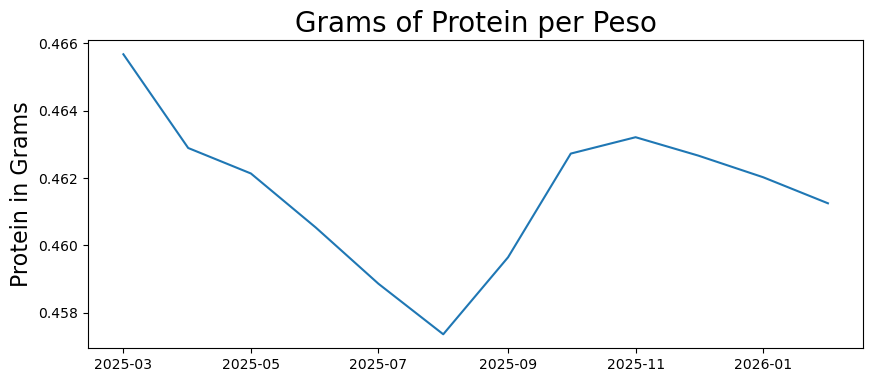

In [61]:
plt.figure(figsize=(10,4))

plt.plot(protein_projection)

plt.title('Grams of Protein per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

Text(0, 0.5, 'Protein in Grams')

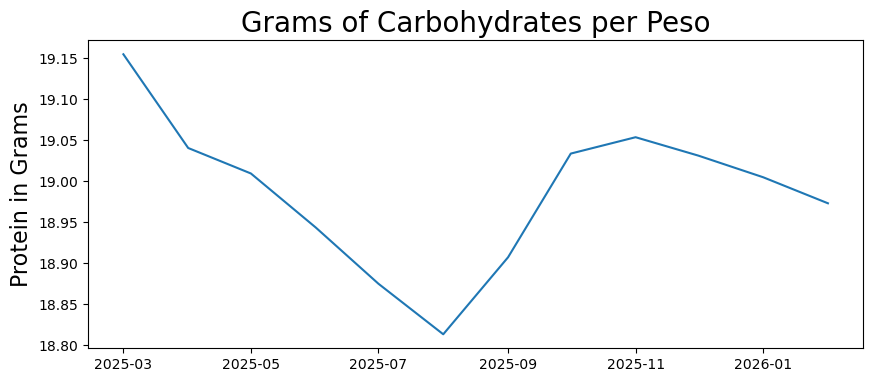

In [62]:
plt.figure(figsize=(10,4))

plt.plot(carbs_projection)

plt.title('Grams of Carbohydrates per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

Text(0, 0.5, 'Protein in Grams')

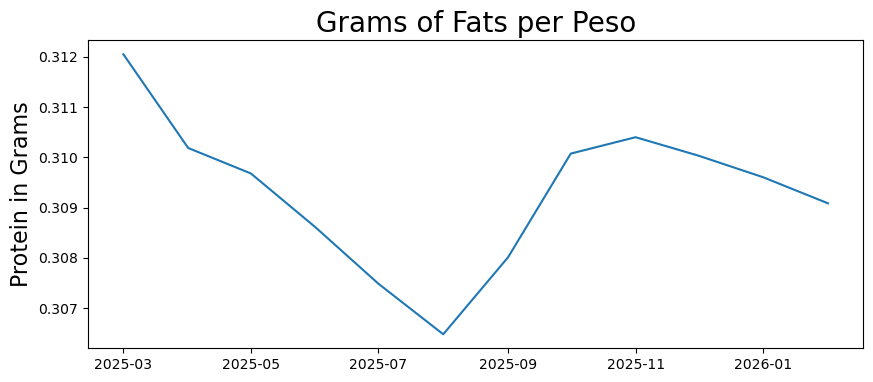

In [63]:
plt.figure(figsize=(10,4))

plt.plot(fats_projection)

plt.title('Grams of Fats per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

Text(0, 0.5, 'Protein in Grams')

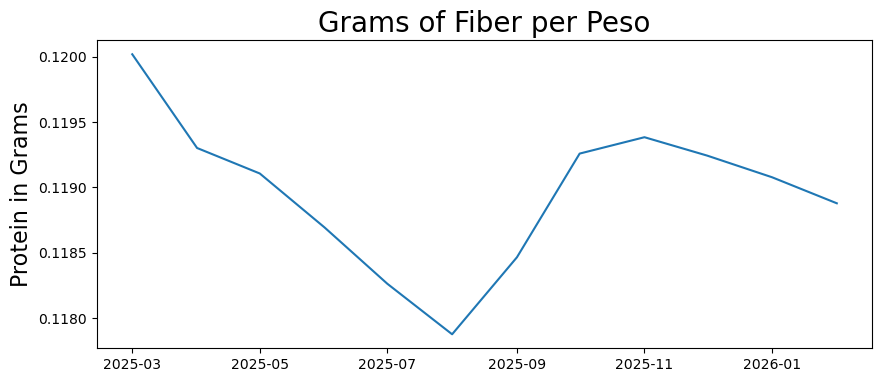

In [64]:
plt.figure(figsize=(10,4))

plt.plot(fiber_projection)

plt.title('Grams of Fiber per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [65]:
protein_projection.to_csv('./protein.csv', index=True)
carbs_projection.to_csv('./carbs.csv', index=True)
fats_projection.to_csv('./fats.csv', index=True)
fiber_projection.to_csv('./fiber.csv', index=True)